In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from bootstrapping.bootstrapping import BootStrapping
from make_representations.representation_maker import Metagenomic16SRepresentation
from classifier.classical_classifiers import RFClassifier,SVM
from classifier.DNN import DNNMutliclass16S
import pandas as pd

Using TensorFlow backend.
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

# Crohn's Disease

### Ler fastaq

In [2]:
# LER OS FASTAQ

# fasta_files: arquivos fastaq
# mapping: orde na que foron lidos/iterados
fasta_files, mapping = FileUtility.read_fasta_directory('../../crohns_disease/samples_fastq/', 'fastq')
#fasta_files, mapping = FileUtility.read_fasta_directory('../../crohns_disease/samples_fastq/', 'fastq', 
#                only_files=["ERR1368879.fastq", "ERR1368880.fastq", "ERR1368881.fastq", 
#                            "ERR1368882.fastq", "ERR1368883.fastq", "ERR1368884.fastq",
#                            "ERR1368885.fastq", "ERR1368886.fastq", "ERR1368887.fastq",
#                            "ERR1368888.fastq", "ERR1368889.fastq", "ERR1368890.fastq"])

### 1. Bootstrapping

In [9]:
# CONSTRUIR OBXECTO PARA O BOOTSTRAPPING
'''
input_dir: input directory or a list of files
output_dir: a directory to generate the output files
sampling_sizes: a list of sampling sizes (N's)
n_resamples: number of resamples from each file (N_R = 10)
seqtype: file suffixes fastq or fasta etc.
M: number of files from the directory to make samplings from (M)
'''

BS=BootStrapping(fasta_files,'../../crohns_disease/results/bootstrapping/', seqtype='fastq',
                 sampling_sizes=[10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000], n_resamples=10, M=10)

In [ ]:
# add k-mer samplings
for k in [3,4,5,6,7,8]:
    print(k,'-mer bootstrapping..')
    BS.add_kmer_sampling(k)

In [19]:
# GARDAR RESULTADOS EN ARQUIVO 'bootstrapping_crohns_disease_prediction' NA RUTA QUE SE LLE INDICOU AO DEFINIR A INSTANCIA BS
BS.save_me('bootstrapping_crohns_disease_prediction')

### 2. k-mer representations

In [ ]:
# ENTRENAMENTO COS MELLORES TAMAÑOS DE K-MER (K) E OS SEUS CORRESPONDENTES TAMAÑOS DE MOSTRA (N) 
# (SEGÚN OS RESULTADOS DE BOOTSTRAPPING)

# dictionary of k-mers and their sampling values
# 6:[100,1000,2000,5000,10000,-1]  :  k-mer:[sampling values]      (-1 means using all sequences)
sampling_dict={3:[20],4:[100],5:[500],6:[100,1000,2000,5000,10000,-1],7:[5000],8:[8000]}
#sampling_dict={6:[5000]}

# number of cores
nump_p=20

# Para cada arquivo fastaq, creamos unha representación por cada posible combinación de tamaño de k-mer e tamaño de mostra, e gardamos os resultados
for k in sampling_dict.keys():  # for each k-mer
    for N in sampling_dict[k]:  # select a sampling size N
        print(k,'-mers with sampling size ',N)
        
        RS=Metagenomic16SRepresentation(fasta_files, mapping, N, nump_p)
        RS.generate_kmers_all(k, save='../../crohns_disease/datasets/dataset_'+str(k)+'-mers_rate_complete1359_seq_'+str(N))
        #RS.generate_kmers_all(k, save='../../crohns_disease/datasets/PRUEBA-dataset_'+str(k)+'-mers_rate_complete1359_seq_'+str(N))

### 3. Classifers

#### Classical Classifiers

In [3]:
# CARGAR O ARQUIVO DE REPRESENTACIÓN K-MERS QUE MELLORES RESULTADOS DESE E OS RESULTADOS DE CLASIFICACIÓN REAIS

# X = matriz con datos:  (nº mostra, nº k-mers da secuencia) Abundancia relativa do k-mer na secuencia
#     en total temos 1359 mostras e 4096 6-mers
# Y = lista de resultados reais:  (CD , not CD)
X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/dataset_6-mers_rate_complete1359_seq_5000.npz')
#X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.npz')
Y=FileUtility.load_list('../../crohns_disease/datasets/labels_disease_complete1359.txt')
#Y=FileUtility.load_list('../../crohns_disease/datasets/PRUEBA-labels_disease_complete1359.txt')

# vemos os datos de X
#dataset=pd.read_csv("../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.csv")
#dataset

In [5]:
# CREAR E ENTRENAR OS CLASIFICADORES E GARDAR OS RESULTADOS 
##### (results containing the best parameter, confusion matrix, best estimator)

################ Random Forest ################
MRF = RFClassifier(X, Y)
MRF.tune_and_eval('../../crohns_disease/results/RFclassifier', n_fold=10, n_jobs=4)

[['Not-CD', 'CD'], array([[388, 240],
       [152, 579]]), 0.7490468409586057, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), {'mean_test_f1_macro': array([0.72783733, 0.73839755, 0.73780639, 0.74388923]), 'std_score_time': array([0.04678118, 0.11887709, 0.09690947, 0.35742904]), 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'split1_test_f1_macro': array([0.

In [ ]:
################ Support Vector Machine ################
MSVM = SVM(X, Y)
MSVM.tune_and_eval('../../crohns_disease/results/SVMclassifier', n_fold=10, n_jobs=4)

#### DNN Classifier

In [2]:
# CARGAR O ARQUIVO DE REPRESENTACIÓN K-MERS QUE MELLORES RESULTADOS DESE E OS RESULTADOS DE CLASIFICACIÓN REAIS

X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/dataset_6-mers_rate_complete1359_seq_5000.npz').toarray()
#X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.npz').toarray()
Y=FileUtility.load_list('../../crohns_disease/datasets/labels_disease_complete1359.txt')
#Y=FileUtility.load_list('../../crohns_disease/datasets/PRUEBA-labels_disease_complete1359.txt')

In [3]:
# CREAR E ENTRENAR OS CLASIFICADORES E GARDAR OS RESULTADOS

################ Multilayer Perceptron  ################
DNN=DNNMutliclass16S(X, Y, model_strct='mlp', model_arch=[1024,0.2,512,0.2,256,0.1,128,8])
DNN.tune_and_eval('../../crohns_disease/results/MLPclassifier', gpu_dev='1', n_fold=10, epochs=100, batch_size=1000, save_weights=False)
#DNN.tune_and_eval('../../crohns_disease/results/MLPclassifier', gpu_dev='1', n_fold=2, epochs=1, batch_size=6, save_weights=True)


 Evaluation on a new fold is now get started ..
128/136 [===========================>..] - ETA: 0s
 Evaluation on a new fold is now get started ..
 96/136 [====================>.........] - ETA: 0s
 Evaluation on a new fold is now get started ..
128/136 [===========================>..] - ETA: 0s
 Evaluation on a new fold is now get started ..
136/136 [==============================] - 0s     

 Evaluation on a new fold is now get started ..
 32/136 [======>.......................] - ETA: 0s
 Evaluation on a new fold is now get started ..
 32/136 [======>.......................] - ETA: 0s
 Evaluation on a new fold is now get started ..
136/136 [==============================] - 0s     

 Evaluation on a new fold is now get started ..
 32/136 [======>.......................] - ETA: 0s
 Evaluation on a new fold is now get started ..
 32/136 [======>.......................] - ETA: 0s
 Evaluation on a new fold is now get started ..
135/135 [==============================] - 0s     
[['CD',

In [ ]:
#X_new=DNNMutliclass16S.make_activation_function(X, '../../crohns_disease/results-PRUEBA/DNNclassifier/weights_layers_mlp_1024-0.2-512-0.2-256-0.1-128-8_0.37.pickle')
#X_new=DNN.make_activation_function()
#X_new

### Métricas obtidas (as resumidas están nos .txt)

In [7]:
metrics=pd.read_csv("../../crohns_disease/results/RFclassifier/all_metrics.csv") # RF
#metrics=pd.read_csv("../../crohns_disease/results/SVMclassifier/all_metrics.csv") # SVM
metrics

,Unnamed: 0,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1_macro,mean_test_f1_micro,mean_test_precision_macro,mean_test_precision_micro,mean_test_recall_macro,mean_test_recall_micro,...,std_fit_time,std_score_time,std_test_accuracy,std_test_f1_macro,std_test_f1_micro,std_test_precision_macro,std_test_precision_micro,std_test_recall_macro,std_test_recall_micro,std_test_roc_auc
0,0,0.274773,0.048121,0.583333,0.500000,0.583333,0.500,0.583333,0.6250,0.583333,...,0.015310,0.008291,0.083333,0.166667,0.083333,0.250,0.083333,0.1250,0.083333,0.125000
1,1,0.392367,0.107916,0.583333,0.500000,0.583333,0.500,0.583333,0.6250,0.583333,...,0.007053,0.004524,0.083333,0.166667,0.083333,0.250,0.083333,0.1250,0.083333,0.222222
2,2,1.625224,0.407611,0.500000,0.409524,0.500000,0.475,0.500000,0.5625,0.500000,...,0.046510,0.030360,0.000000,0.076190,0.000000,0.225,0.000000,0.0625,0.000000,0.076389
3,3,4.355545,0.769961,0.583333,0.500000,0.583333,0.500,0.583333,0.6250,0.583333,...,0.123378,0.100070,0.083333,0.166667,0.083333,0.250,0.083333,0.1250,0.083333,0.013889


### Matrices de confusión

In [4]:
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline 
from utility.visualization_utility import create_mat_plot

Populating the interactive namespace from numpy and matplotlib


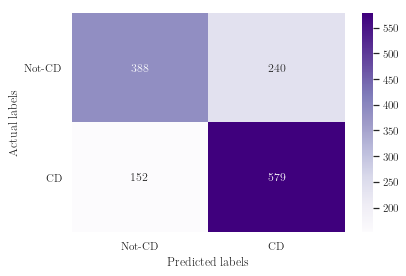

<Figure size 432x288 with 0 Axes>

In [3]:
################ Random Forest ################
# load the results
[label_set, conf, best_score_, best_estimator_, cv_results_, best_params_, predictions]=FileUtility.load_obj('../../crohns_disease/results/RFclassifier/all_results.pickle')
label_set=[x.replace('_',' ') for x in label_set]

# create the plot (Confusion matrix) and save it in a pdf
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/RFclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf',font_s=8)

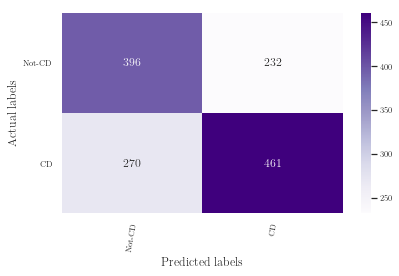

<Figure size 432x288 with 0 Axes>

In [4]:
################ Support Vector Machine ################
[label_set, conf, best_score_, best_estimator_,cv_results_, best_params_, predictions]=FileUtility.load_obj('../../crohns_disease/results/SVMclassifier/all_results.pickle')
label_set=[x.replace('_',' ') for x in label_set]
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/SVMclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf', rx=80, ry=0, font_s=15)

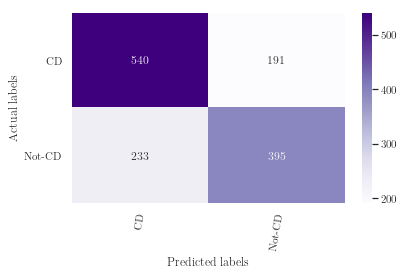

<Figure size 432x288 with 0 Axes>

In [6]:
################ Multilayer Perceptron ################
[labels_alphanum, conf, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, accuracy, roc_auc, (loss_values, val_loss_values, epochs)]=FileUtility.load_obj('../../crohns_disease/results/MLPclassifier/results_mlp_1024-0.2-512-0.2-256-0.1-128-8_0.68.pickle')
label_set=[x.replace('_',' ') for x in labels_alphanum]
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/MLPclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf', rx=80, ry=0, font_s=15)

In [13]:
conf

array([[0, 5],
       [0, 7]])